In [11]:
# Packages for data processing 
import numpy as np, pandas as pd, math
# Packages for webpage crawling
import requests as r
from bs4 import BeautifulSoup as BS
# Packages for nature language processing
import spacy, pyinflect
from pyinflect import getAllInflections
import nltk,emoji,string,re
from collections import Counter
from nltk.corpus import stopwords as sw
from nltk.util import ngrams as ng
from nltk.tokenize import word_tokenize as tk
from nltk.stem import WordNetLemmatizer as wn
import gender_guesser.detector as gen
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import sentiwordnet as swn
# Packages for machine learning (sklearn, bert_based model)
from sklearn.preprocessing import MinMaxScaler
# from flair.models import TextClassifier
# from flair.data import Sentence
from scipy.special import softmax
import tweetnlp
# Packages for Twitter API and configuration
import tweepy as tw, configparser  
# Packages about time
import time as t, datetime as dt, rfc3339
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
# Packages for visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

ImportError: cannot import name 'allowed_transitions' from 'allennlp.modules.conditional_random_field' (c:\Users\ky002\AppData\Local\Programs\Python\Python39\lib\site-packages\allennlp\modules\conditional_random_field\__init__.py)

In [4]:
# Reqest the webpages including the synonymsous words or meanings of these topics: car, buy, and drive
car_url='https://www.thesaurus.com/browse/car'
buy_url='https://www.thesaurus.com/browse/buy'
buying_url='https://www.thesaurus.com/browse/buying'
drive_url='https://www.thesaurus.com/browse/drive'

# Crawling the synonyms of four topics: (car, buy, buying, drive) from Thesurus.com
def keywordExtract(url_name,class_name):
    page_name=r.get(url_name)
    soup_name=BS(page_name.content,'html.parser')
    key_soup=soup_name.find('ul', class_=class_name).find_all('a')
    list_name=[]
    for key in key_soup:
        new_key=key['href'][8:].replace('%20',' ')
        list_name.append(new_key)
    return list_name

# I only captured the red-marked words which contain the most closed meanings as the chosen topics
car_sym=keywordExtract(car_url,'css-1xohnkh e1ccqdb60')[:14]
car_sym.insert(0,'car')
buy_sym=keywordExtract(buy_url,'css-wmtunb e1ccqdb60')[:4]
buy_sym.insert(0,'buy')
buying_sym=keywordExtract(buying_url,'css-1lj4erq e1ccqdb60')[:3]
buying_sym.insert(0,'buying')
buy_sym=buy_sym+buying_sym
drive_sym=keywordExtract(drive_url,'css-n85ndd e1ccqdb60')[:4]
drive_sym.insert(0,'drive')

# Altough I have got thirty words as required keywords for tweet requests, it is recommended to include different tenses or forms of words 
#, as many Twitter users will use them depending on different contents.
nlp = spacy.load('en_core_web_sm')

buy_str=' '.join(buy_sym)
buy_doc=nlp(buy_str)
buy_extension_list=[]
for num in range(len(buy_doc)):
    token = buy_doc[num]
    if token.tag_ in ['NN','VB','VBG']:
        buy_extension_list.append(token._.inflect('VB',inflect_oov=True))
buy_extension_list=[ele for ele in list(set(buy_extension_list+['invest','shop','transact'])) if ele]

def extension(sym):
    sym_str=' '.join(sym)
    sym_token=nlp(sym_str)
    extension_list=[]
    for num in range(len(sym_token)):
        token = sym_token[num]
        if token.tag_ in ['NN','VB','VBG']:
            if str(token)!=token._.inflect('VBD',inflect_oov=True)[:len(token)]:
                extension_list.append(token._.inflect('VBD',inflect_oov=True))              
            if str(token)!=token._.inflect('VBG',inflect_oov=True)[:len(token)]:
                 extension_list.append(token._.inflect('VBG',inflect_oov=True))
            if str(token)!=token._.inflect('VBN',inflect_oov=True)[:len(token)]:
                 extension_list.append(token._.inflect('VBN',inflect_oov=True))
            if str(token)!=token._.inflect('VBZ',inflect_oov=True)[:len(token)]:
                 extension_list.append(token._.inflect('VBZ',inflect_oov=True))
    return extension_list

buy_sym=list(set(extension(buy_extension_list)+buy_extension_list))
buy_sym.append('acquisition')

drive_sym=list(set(extension(drive_sym)+drive_sym))

# According to car registration records of the UK from 2019 to 2022, the top 10 sales brands were selected as they might be mentioned more frequently than the other brands when talking about automative topics
brand_list=['Ford','BMW','Volkswagen','Mercedes-Benz','Audi','Vauxhall','Toyota','Kia','Hyundai','Land Rover']

#While searching for Google Trends data, various spellings or expressions that a user could use while posting about a car model were checked.
brand_abb=['VW','Mercedes','Voho','Landy','Bimmer','MBZ']

# The most popular Car sale Models in the UK, as a same replacement of the brand name: One model for one brand
brand_model=['fiesta','corolla','Series','polo','sportage','tucson','corsa','A-Class','discovery','A3']

# Name of car types when people are talking a series of car
car_type=['coupe','hatchback','sedan','sports','suv']

# Names of many important parts of car are also added in as I found that is a part of comments when people value their cars:15 most important words from https://www.collinsdictionary.com/word-lists/car-parts-of-a-car
car_tool=['grip','bumper','tyre','brake','bonnet','airbag','carburettor','piston','engine','battery','fuel tank','hood','steering wheel','accelerator','seatbelt']
#But there isn't such words like automobiling/automobiled or jeeping/jeeped, so it has to be deleted
car_sym.remove('ride')
car_sym.append('vehicle')

def dfGenerator(name,list):
    return pd.DataFrame({name:list})
#Put all the words into a dataframe sorted by different segements.
keywords=pd.concat([dfGenerator('Car',car_sym),
                    dfGenerator('Buy',buy_sym),
                    dfGenerator('Drive',drive_sym),
                    dfGenerator('Brand',brand_list),
                    dfGenerator('Brand Abbreviation',brand_abb),
                    dfGenerator('Brand Model',brand_model), 
                    dfGenerator('Car Tool',car_tool),
                    dfGenerator('Car Type',car_type)],
                    axis=1)
print(keywords)

# To limit the search zone that has to contain the elements of car, purchase, drive 
keylist_of_car=car_sym+brand_list+brand_abb+brand_model+car_tool+car_type
keylist_of_buy=buy_sym
keylist_of_drive=drive_sym

#Build the content of query: element 'car' is compulsory which the other elements are optional
query_content='('+' '.join(keylist_of_car).replace(' ',' OR ')+') ('+' '.join(keylist_of_buy+keylist_of_drive).replace(' ',' OR ')+') lang:en place_country:GB -is:nullcast -has:links'
print(len(query_content), query_content)
# Build and read the config for password safety
config=configparser.RawConfigParser()
config.read('config.ini')

api_key=config['twitter']['api_key']
api_key_secret=config['twitter']['api_key_secret']
access_token=config['twitter']['access_token']
access_token_secret=config['twitter']['access_token_secret']
bearer_token=config['twitter']['bearer_token']

# Authtication of my Twitter api
client = tw.Client(bearer_token,api_key, api_key_secret,access_token, access_token_secret,wait_on_rate_limit=True)

# Building the timestrap of each hour
def dateRange(start_date, end_date):
    while start_date <= end_date:
        yield start_date
        start_date+=dt.timedelta(hours=8)

# Set the starting at the first hour of Feburary 1st 2019 and the end time at the same hour of October 1st 2021
start_date_1_1 = datetime(2019, 2, 1, 0, 00,00)
end_date_1_1 = datetime(2019, 4, 1, 0, 00,00)
start_date_1_2 = datetime(2019, 8, 1, 0, 00,00)
end_date_1_2 = datetime(2019, 10, 1, 0, 00,00)

start_date_2_1 = datetime(2020, 2, 1, 0, 00,00)
end_date_2_1 = datetime(2020, 4, 1, 0, 00,00)
start_date_2_2 = datetime(2020, 8, 1, 0, 00,00)
end_date_2_2 = datetime(2020, 10, 1, 0, 00,00)

start_date_3_1 = datetime(2021, 2, 1, 0, 00,00)
end_date_3_1 = datetime(2021, 4, 1, 0, 00,00)
start_date_3_2 = datetime(2021, 8, 1, 0, 00,00)
end_date_3_2 = datetime(2021, 10, 1, 0, 00,00)

# remember to change about the time

def time_builder(start_date,end_date):
    time=[]
    for single_date in dateRange(start_date, end_date):
        time.append(single_date.strftime("%Y-%m-%d %H:%M:%S"))
    return time

first_time_1=time_builder(start_date_1_1,end_date_1_1)[:-1]+time_builder(start_date_1_2,end_date_1_2)[:-1]
second_time_1=time_builder(start_date_1_1,end_date_1_1)[1:]+time_builder(start_date_1_2,end_date_1_2)[1:]

first_time_2=time_builder(start_date_2_1,end_date_2_1)[:-1]+time_builder(start_date_2_2,end_date_2_2)[:-1]
second_time_2=time_builder(start_date_2_1,end_date_2_1)[1:]+time_builder(start_date_2_2,end_date_2_2)[1:]

first_time_3=time_builder(start_date_3_1,end_date_3_1)[:-1]+time_builder(start_date_3_2,end_date_3_2)[:-1]
second_time_3=time_builder(start_date_3_1,end_date_3_1)[1:]+time_builder(start_date_3_2,end_date_3_2)[1:]

def rfcTimeConvetor(time_list):
    new_time_list=[]
    for single_record in time_list:
        datetime_object = datetime.strptime(single_record, "%Y-%m-%d %H:%M:%S")
        rfc_records=rfc3339.rfc3339(datetime_object)
        new_time_list.append(rfc_records)
    return new_time_list

rfc_first_time=rfcTimeConvetor(first_time_1)+rfcTimeConvetor(first_time_2)+rfcTimeConvetor(first_time_3)
rfc_second_time=rfcTimeConvetor(second_time_1)+rfcTimeConvetor(second_time_2)+rfcTimeConvetor(second_time_3)

              Car          Buy    Drive          Brand Brand Abbreviation  \
0             car      bargain      run           Ford                 VW   
1            auto     transact   riding            BMW           Mercedes   
2      automobile    acquiring     trip     Volkswagen               Voho   
3             bus     purchase    drive  Mercedes-Benz              Landy   
4     convertible         shop     ride           Audi             Bimmer   
5            jeep      acquire  driving       Vauxhall                MBZ   
6       limousine       invest     rode         Toyota                NaN   
7         machine   purchasing    drove            Kia                NaN   
8           motor       bought     tour        Hyundai                NaN   
9          pickup          buy   ridden     Land Rover                NaN   
10  station wagon  acquisition      NaN            NaN                NaN   
11          truck          NaN      NaN            NaN                NaN   

In [3]:
# # Retrieve all the required data from Twitter API from each eight hours per day of three years
# for start_time, end_time in zip(rfc_first_time,rfc_second_time):
#     tweet_info_small_list=[]
#     tweets=client.search_all_tweets(
#                             query_content,                            
#                             end_time=end_time,       
#                             start_time=start_time,
#                             tweet_fields = ["created_at", "text", "lang"],
#                             user_fields = ['name', 'username', "location"],
#                             sort_order=['relevancy'],
#                             expansions='author_id',
#                             max_results=100)
#     for tweet,user in zip(tweets.data,tweets.includes['users']):
#         tweet_info = {
#         'created_at': tweet.created_at,
#         'text': tweet.text,
#         'source': tweet.source,
#         'name': user.name,
#         'username': user.username,
#         'location': user.location}
#         tweet_info_small_list.append(tweet_info)
#     tweets_datasource = pd.DataFrame(tweet_info_small_list)
#     tweets_datasource.to_csv('C:/home2/hzhx55/Dissertation/TwData_300.csv',sep=',', mode='a',encoding='utf_8')

In [6]:
#Get rid of the empty lines and sort all the data by the time it happened
raw_data=pd.read_csv('TwData_300.csv',sep=',',header=0,encoding='utf_8')
raw_data=raw_data.drop(columns=['Unnamed: 0','source'])
raw_data=raw_data[raw_data['text']!='text'].sort_values(by='created at').reset_index(drop=True)

def treatmentMarker(row):
    if row['created at']<'2019-10-01 00:00:00+00:00':
        answer='before covid'
    else:
        answer='after covid'
    return answer

raw_data['treatment/control']=raw_data.apply(treatmentMarker,axis=1)

#Remove all the emoji used in the text
def emojiFreeText(text):
    pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FC"  # transport & map symbols
        u"\U0001F1E6-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u200a-\u200f"
        "]+", 
        flags = re.UNICODE)
    return pattern.sub(r'',text)
    
#Remove all the puntutation and number used in the text
def puntuationFreeText(text):
    tab=str.maketrans(dict.fromkeys(string.punctuation))
    pure_text=text.translate(tab)
    pure_text=''.join([let for let in pure_text if not let.isdigit()])
    return pure_text

def removeMeaninglessName(text):
    exclude_words_of_name=sw.words('english')
    new_name=[]
    for word in text.split():
        if word not in exclude_words_of_name:
            new_name.append(word)
    return ' '.join(new_name)

# Remove all the space used at the start of sentence, lower the case, and only need the first name of users
def removeSpace(text):
    if len(text)==0:
        text='unknown'
    else:
        if text[0]==' ':
            text=text.lower()[1:]
        else:
            text=text.lower()
    return text

def removeAlpha(text):
    for word in text.split():
        if len(word)>1:
            pattern=re.compile(word)
            poistion=[match.start() for match in pattern.finditer(text)][0]
            text=text[poistion:]
            break
    return text

gender=['unknown']*len(raw_data.name)
fitered_name_list=[]
gender_list=[]

for nam,sex,username in zip(raw_data.name,gender,raw_data.username):
    name=removeAlpha(removeSpace(removeMeaninglessName(puntuationFreeText(emojiFreeText(nam)))))
    if (name[0:3]=='sir'and len(name.split()[0])==3):
        name=name[4:]
        sex='male'
    elif (name[0:2]=='mr'and len(name.split()[0])==2):
        name=name[3:]
        sex='male'
    elif (name[0:2]=='dr'and len(name.split()[0])==2):
        name=name[3:]
        sex='male'
    elif (name[0:4]=='prof' and len(name.split()[0])==4):
        name=name[5:]
        sex='male'
    elif (name[0:4]=='miss' and len(name.split()[0])==4):
        name=name[5:]
        sex='female'
    elif (name[0:5]=='madam'and len(name.split()[0])==5):
        name=name[6:]
        sex='female'
    elif (name[0:4]=='lady'and len(name.split()[0])==4):
        name=name[5:]
        sex='female'
    elif (name[0:2]=='ms'and len(name.split()[0])==2):
        name=name[3:]
        sex='female'
    elif (name[0:3]=='mrs'and len(name.split()[0])==3):
        name=name[4:]
        sex='female'
    elif (name[0:5]=='nurse'):
        name=name[6:]
        sex='female'
    elif (name[0:2]=='mx'and len(name.split()[0])==2):
       name=name[3:]
       sex='unknown'
    if len(name.split())==0:
        name='unknown'
    else:
        first_name = ''.join([word for word in name.split()[0] if word!='unknown'])
        first_name =''.join([word[0].upper() + word[1:] for word in first_name.split()])
        if len(re.findall('([A-Z][a-z]+)', first_name))!=0:
            first_name=re.findall('([A-Z][a-z]+)', first_name)[0]
        else:
            first_name=removeAlpha(removeSpace(puntuationFreeText(username)))
            first_name =''.join([word[0].upper() + word[1:] for word in first_name.split()])
            first_name=re.findall('([A-Z][a-z]+)', first_name)[0]
            if len(first_name)<=2 or len(first_name)>10:
                first_name=max(first_name.split(), key=len)
    if len(first_name)>10:
        origin_name=removeAlpha(removeMeaninglessName(puntuationFreeText(emojiFreeText(nam))))
        if len(re.findall('([A-Z][a-z]+)', origin_name))!=0:
            first_name=re.findall('([A-Z][a-z]+)', origin_name)[0]
    fitered_name_list.append(first_name)
    gender_list.append(sex)

raw_data['first name']=pd.DataFrame(fitered_name_list)
raw_data['gender']=pd.DataFrame(gender_list)
known_name=raw_data['first name'].loc[raw_data['gender'] =='unknown']
detector=gen.Detector()
raw_data['predicted gender']=raw_data['first name'].apply(lambda a: detector.get_gender(a))
raw_data['gender'].loc[(raw_data['gender']=='unknown')] = raw_data['predicted gender']

raw_data.loc[(raw_data['gender']=='mostly_female'),'gender']='female'
raw_data.loc[(raw_data['gender']=='mostly_male'),'gender']='male'
raw_data.loc[(raw_data['gender']=='andy'),'gender']='unknown'
raw_data=raw_data.drop(columns=['predicted gender'])

#Assume the people who live in the city have better purchasing power than people who live outside the city
london=['london']
southeast=['oxford','portsmouth','southampton','reading','brighton','milton keynes','slough','southend-on-sea','luton']
southwest=['bath','bristol','plymouth','gloucester','bournemouth','poole']
northwest=['manchester','liverpool','lancaster','warrington','bolton','blackpool']
northeast=['newcastle','durham','sunderland']
yorkshire=['york','leeds','bradford','kingston','sheffield','huddersfield','middlesbrough']
west_midland=['birmingham','coventry','stoke-on-trent','wolverhampton','swindon','wolverhampton','telford']
east_midland=['derby','nottingham','leicester','northampton','cambridge','peterborough']
scotland=['edinburgh','glasgow','aberdeen','dundee']
wales=['cardiff','swansea']
northern_ireland=['belfast']
new_location=[]
for location in raw_data.location:
    if type(location)==float:
        location='unknown'
    else:
        location=location.split(',')[0].lower()
    if location=='uk' or location=='united kingdom':
        location='unknown'
    elif any(city in location for city in london):
        location='london'
    elif any(city in location for city in southeast):
        location='southeast'
    elif any(city in location for city in southwest):
        location='southwest'
    elif any(city in location for city in northwest):
        location='northwest'
    elif any(city in location for city in northeast):
        location='northeast'
    elif any(city in location for city in west_midland):
        location='west midland'
    elif any(city in location for city in east_midland):
        location='east midland'
    elif any(city in location for city in yorkshire):
        location='yorkshire'
    elif any(city in location for city in scotland):
        location='scotland'
    elif any(city in location for city in wales):
        location='wales'
    elif any(city in location for city in northern_ireland):
        location='northern ireland'
    else:
        location='other towns and places'
    new_location.append(location)
raw_data.insert(loc=5, column='new_location', value=new_location)
    
#Remove all the contact signs and people names mentioned inside the text
# Too many emoji with the same content but I can't remove them and they will pollute the word source
def deleteRepetition(emoji_content, max_times=2):
    emoji=list(emoji_content)
    emotion=' '.join(emoji_content)
    checklist = [lab for lab in dict.fromkeys(emoji) if emoji.count(lab) > 1]
    for i in range(len(checklist)):
       while(emoji.count(checklist[i]) > max_times):
           emoji.remove(checklist[i])
           emotion=''.join(emoji)
    return emotion

def removeDuplicateEmoji(text):
    pure_text=emojiFreeText(text)
    duplicate_emoji = []
    for emo in text:
        if emo in (emoji.UNICODE_EMOJI['en'] or emoji.UNICODE_EMOJI['es'] or emoji.UNICODE_EMOJI['pt'] or emoji.UNICODE_EMOJI['it']):
            duplicate_emoji.append(emo)
    twice_maximum=deleteRepetition(duplicate_emoji)
    text=pure_text+twice_maximum
    return text

def freeContact(text):
    pattern = re.compile("@+")
    if len(re.findall(pattern,text))!=0:
        pattern = re.compile("@+")
        times=len([match.span() for match in pattern.finditer(text)])
        time=0
        while time<times:
            poistion=[match.start() for match in pattern.finditer(text)][0]
            text=text[:poistion]+text[poistion+len(text[poistion:].split()[0]):]
            text=text.replace("  ", " ")
            time+=1
        else:
            text=text
    return text

#Restore all emoji into readable meanings
def emojiLemon(text):
    return emoji.demojize(text, delimiters=("", " ")) 

def singleQuoteTransfer(text):
    text=re.sub("  "," ",text)
    text=re.sub("'ve"," have",text)
    text=re.sub("'d"," would like to",text)
    text=re.sub("n't"," not",text)
    text=re.sub("'m"," am",text)
    text=re.sub("'s"," is",text)
    text=re.sub("_"," ",text)
    text=re.sub('hrs','hours', text)
    text=re.sub('pls','please', text)
    text=re.sub('bf','boyfriend',text)
    text=re.sub('dcpc','driver certificate of professional competence', text)
    text=re.sub('celebs','celebrities', text)
    return text

#remove all the tags used in sentences
def removeTag (text):
    text=' '.join([letter for letter in text.split() if not len(letter)>=15])
    text=text.lower()
    text=re.sub('n not',' not',text)
    text=re.sub('ca not','can not',text)
    return text

#remove all punctuation used in sentences
def removePunc(text):
    text = re.sub(r'''\W+\s*''',' ',text,flags=re.VERBOSE)
    text=''.join([let for let in text if not let.isdigit()])
    return text

#remove all two-letter words and some meaningless abbreviations in sentences
def meaninglessWordRemove(text):
    new_sw=sw.words('english')
    new_sw=list(set(new_sw+list(string.ascii_lowercase)))+['much','many','lol','etc','yeah','ummm','haha','omg','hmmm']
    new_sw.remove('not')
    new_text=[]
    for word in text.split():
        if len(word)>2:
            new_text.append(word)
    text=' '.join([word for word in new_text if word not in new_sw])
    return text

def sentenceLemon(text):
        lemon = wn()
        each_lemmon_str = ' '.join([lemon.lemmatize(word) for word in tk(text)])
        allow_postags = set(['NOUN', 'VERB', 'ADJ', 'ADV', 'PROPN'])
        words = []
        for token in nlp(each_lemmon_str):
            if token.pos_ in allow_postags:
                words.append(token.lemma_)
        return ' '.join(words)

def abbrChange(text):
    cos='cos'
    bcos='bcos'
    rd='rd'
    mon='mon'
    tue='tues'
    wed='wed'
    thu='thu'
    fri='fri'
    sat='sat'
    tfl='tfl'
    wm='washing machine'
    text=re.compile(r'\b%s\b' % cos, re.I).sub('because',text)
    text=re.compile(r'\b%s\b' % bcos, re.I).sub('because',text)
    text=re.compile(r'\b%s\b' % rd, re.I).sub('road',text)
    text=re.compile(r'\b%s\b' % mon, re.I).sub('monday',text)
    text=re.compile(r'\b%s\b' % tue, re.I).sub('tuesday',text)
    text=re.compile(r'\b%s\b' % wed, re.I).sub('wednesday',text)
    text=re.compile(r'\b%s\b' % thu, re.I).sub('thursday',text)
    text=re.compile(r'\b%s\b' % fri, re.I).sub('friday',text)
    text=re.compile(r'\b%s\b' % sat, re.I).sub('saturday',text)
    text=re.compile(r'\b%s\b' % tfl, re.I).sub('transport london',text)
    text=re.compile(r'\b%s\b' % wm, re.I).sub('engine machine',text) 
    return text

# Process the original text by sequence of functions
def dataProcessingAuto(text):
    processed_text=sentenceLemon(
        abbrChange(
            meaninglessWordRemove(
                removeTag(
                    removePunc(
                        singleQuoteTransfer(
                            emojiLemon(
                                freeContact(
                                    removeDuplicateEmoji(text)))))))))
    return processed_text

raw_data['new_processed_text']=raw_data['text'].apply(dataProcessingAuto)
print('The capacity of the dataset is:',len(raw_data))

def dataProcessingAutoEmojiFree(text):
    processed_text=sentenceLemon(
        abbrChange(
            meaninglessWordRemove(
                removeTag(
                    removePunc(
                        singleQuoteTransfer(
                            emojiLemon(
                                freeContact(
                                    emojiFreeText(text)))))))))
    return processed_text
raw_data['emoji_processed_text']=raw_data['text'].apply(dataProcessingAutoEmojiFree)

The capacity of the dataset is: 35823


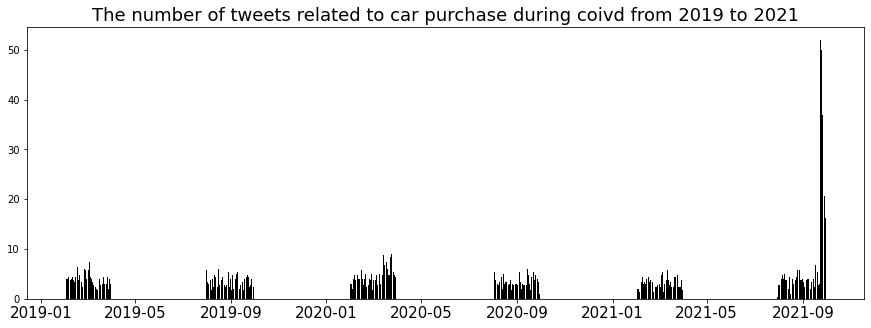

['buy new car', 'get car drive', 'mile round trip', 'ice cream van', 'red ride hood', 'rear wheel drive', 'car drive home', 'open top bus', 'panic buy fuel', 'drive car park', 'brother tony kill', 'buy electric car', 'park amp ride', 'car hit walk', 'use public transport', 'little red ride', 'self drive car', 'buy brand new', 'top bus tour', 'bus driver drive', 'brand new car', 'get new car', 'hire car drive', 'wrong side road', 'pass drive test', 'drive bus lane', 'car park drive', 'buy second hand', 'drive new car', 'buy first car', 'car drive back', 'bus ride away', 'people panic buy', 'bus ride home', 'car boot sale', 'walk home night', 'front wheel drive', 'drive straight past', 'panic buying fuel', 'drive home work', 'drive petrol station', 'auto body paint', 'body paint shop', 'driving consider follow', 'second hand car', 'buy engine machine', 'test drive car', 'bus drive past', 'drive electric car', 'pay road tax']
similarity ratio_1_2 : 0.54
similar words_2_3 : ['bus drive', '

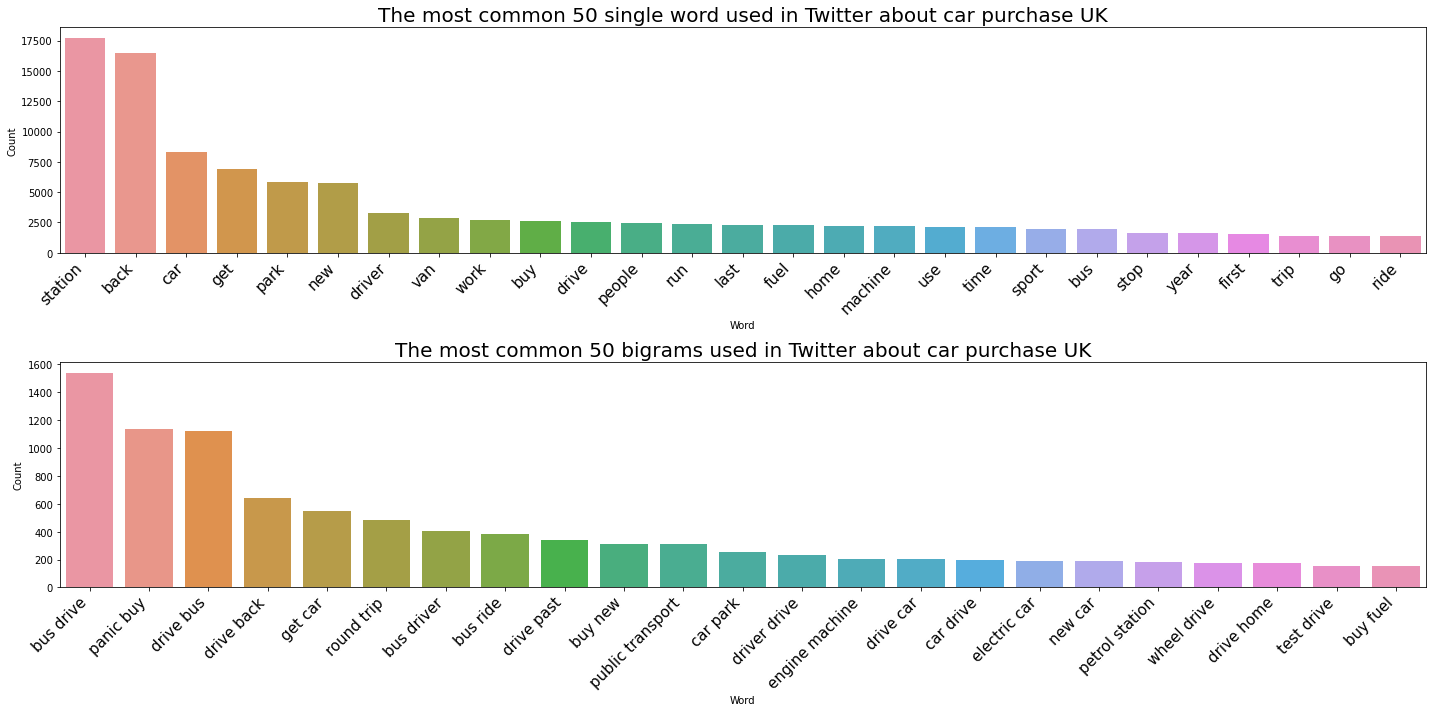

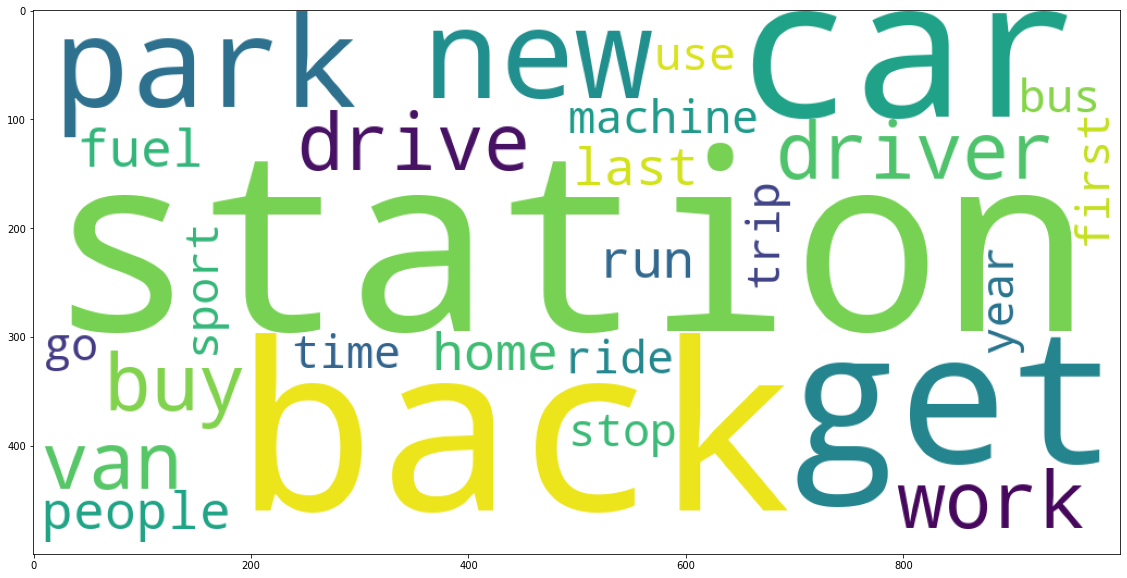

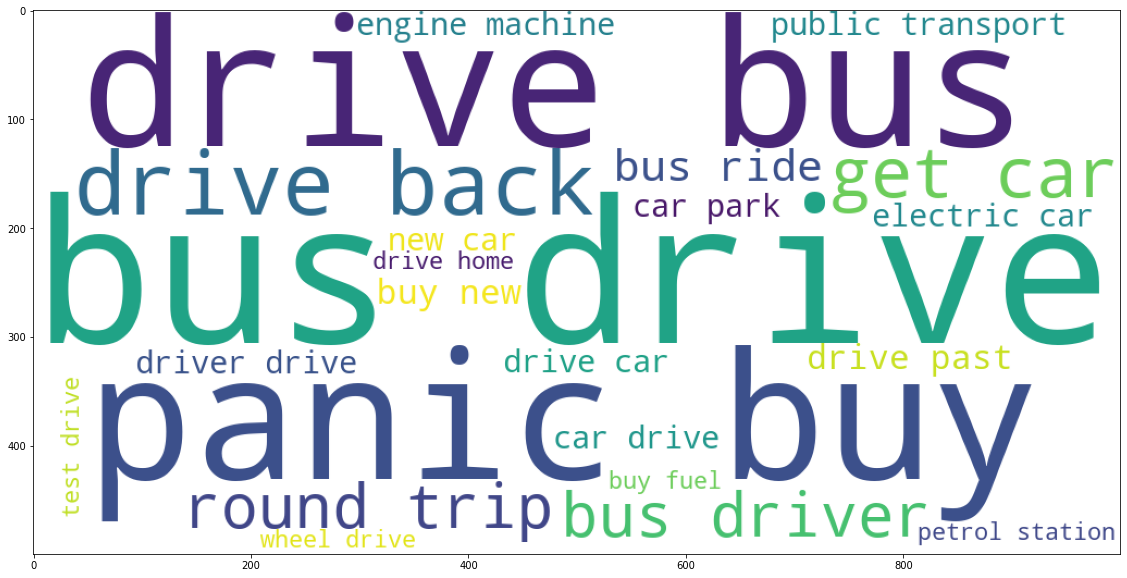

In [7]:
#Time-series analysis about Related Topics
def timeChange(time):
    return datetime.fromisoformat(time[:4]+'-'+time[4:6]+'-'+time[6:8])
keyword_list=['drive','car','buy']
additional_list=['fuel','electric','panic','tax','second hand','petrol','used','expenditure','covid','recession','income','salary','redundancy','unemployment','leave','substitution','brexit','war']
raw_data['date']=raw_data['created at'].apply(timeChange)
raw_data['inside or not']=raw_data['new_processed_text'].loc[raw_data['new_processed_text'].apply(lambda sentence:any([word in sentence for word in keyword_list]))==True].apply(lambda sentence: any([word in sentence for word in additional_list]))
dftweetcount=raw_data.groupby('date')['inside or not'].apply(lambda x: np.round((x==True).sum()/3,decimals=1)).reset_index(name='count')
date = dftweetcount['date']
value = dftweetcount['count']
xtick = np.linspace(0, 6 , 1)
plt.figure(figsize=(15,5))
plt.bar(date, value, color='black')
plt.xticks(fontsize=15)
plt.title('The number of tweets related to car purchase during coivd from 2019 to 2021',fontsize=18)
plt.show()

#Get all tweets for word frequency check
all_processed_tweets=' '.join([tweets for tweets in raw_data['emoji_processed_text']])

# Extract the most frequent word chunk
def extractNearestWords(data, dim):
    n_grams = ng(tk(data), dim)
    return [ ' '.join(grams) for grams in n_grams]

# Count the the top 50 most frequent words in one word, two, and three word chunks
fifty_one_word = Counter(all_processed_tweets.split()).most_common(50)
fifty_two_word=Counter(extractNearestWords(all_processed_tweets,2)).most_common(50)
fifty_three_word=Counter(extractNearestWords(all_processed_tweets,3)).most_common(50)

def wordAndCount(one_word):
    one_word_list=[]
    one_word_list_count=[]
    for key in one_word:
      one_word_list.append(key[0])
      one_word_list_count.append(key[1])
    return one_word_list,one_word_list_count

one_word,one_word_count=wordAndCount(fifty_one_word)
two_word,two_word_count=wordAndCount(fifty_two_word)
three_word,three_word_count=wordAndCount(fifty_three_word)
print(three_word)

similar_words_1_2=list(set([word for word in one_word if word in ' '.join([one for one in two_word]).split()]))
print('similarity ratio_1_2 :', len(similar_words_1_2)/len(two_word))

similar_words_2_3=[]
for word in two_word:
    for words in three_word:
        if word in words:
            similar_words_2_3.append(word)
similar_words_2_3=list(set(similar_words_2_3))
print('similar words_2_3 :', similar_words_2_3)
print('similarity ratio_2_3 :', len(similar_words_2_3)/len(three_word))

def similarWordCount(similar_words,one_word):
    value=[]
    for word in similar_words:
        for key in one_word:
            if word==key[0]:
                value.append(key[1])
    return value

similar_words_1_2_count=similarWordCount(similar_words_1_2,fifty_one_word)
similar_words_2_3_count=similarWordCount(similar_words_2_3,fifty_two_word)

df_similar_words_1_2=pd.DataFrame({'Word':similar_words_1_2,'Count':similar_words_1_2_count})
df_similar_words_2_3=pd.DataFrame({'Word':similar_words_2_3,'Count':similar_words_2_3_count})

#Visualization for single and dural word chunk
fig, axes = plt.subplots(2,1, figsize=(20,10))

sns.barplot(x ='Word', y ='Count', data=df_similar_words_1_2,order=df_similar_words_1_2.sort_values('Count',ascending = False).Word,ax=axes[0])
axes[0].set_xticklabels(similar_words_1_2,rotation=45, ha="right",fontsize=15)
axes[0].set_title('The most common 50 single word used in Twitter about car purchase UK', fontsize=20)
sns.barplot(x ='Word', y ='Count', data=df_similar_words_2_3,order=df_similar_words_2_3.sort_values('Count',ascending = False).Word,ax=axes[1])
axes[1].set_xticklabels(similar_words_2_3,rotation=45, ha="right",fontsize=15)
axes[1].set_title('The most common 50 bigrams used in Twitter about car purchase UK', fontsize=20)
plt.tight_layout()
plt.show()

sw1='similar_words_1_2'
sw2='similar_words_2_3'

#word-cloud for twitter
def wordCloudGenerator(similar_word,sw):
    plt.figure(figsize = (45,10))
    word_could_dict=Counter(similar_word)
    wordcloud = WordCloud(background_color='white',width = 1000, height = 500).generate_from_frequencies(word_could_dict)
    plt.savefig(sw+'.png')
    plt.imshow(wordcloud)

wordCloudGenerator(similar_words_1_2,sw1)
wordCloudGenerator(similar_words_2_3,sw2)

In [8]:
# Combination of lexicon-based models for sentimental analysis
def textBlobSentimentAnalysis(sentiment_text):
    blob_attitude = TextBlob(sentiment_text).sentiment.polarity
    return blob_attitude

blob_attitude_list=[]    
for text in raw_data['new_processed_text']:
    blob_attitude=textBlobSentimentAnalysis(text)
    blob_attitude_list.append(blob_attitude)
blob_attitude_score=np.array(blob_attitude_list).reshape(-1,1)
scaler = MinMaxScaler(feature_range=(-1, 1))
textblob_result=scaler.fit_transform(blob_attitude_score).flatten()

def vadorSentimentAnalysis(sentiment_text):
    score=SentimentIntensityAnalyzer().polarity_scores(sentiment_text)
    vador_pos=score['pos']
    vador_neg=score['neg']
    return vador_pos-vador_neg

vador_attitude_list=[]
for text in raw_data['new_processed_text']:
    vador_attitude=vadorSentimentAnalysis(text)
    vador_attitude_list.append(vador_attitude)
vador_attitude_score=np.array(vador_attitude_list).reshape(-1,1)
vador_result=scaler.fit_transform(vador_attitude_score).flatten()

def sentiwordnetAnalysis(sentiment_text):
    posit=[]
    negat=[]
    length_of_sentence=len(sentiment_text)
    range_of_sentence=range(length_of_sentence)
    for word in sentiment_text.split(): 
        each_sentence = swn.senti_synsets(word)
        each_sentence_list=list(each_sentence)
        if len(each_sentence_list)!=0:
            pos=each_sentence_list[0].pos_score()
            neg=each_sentence_list[0].neg_score()
            posit.append(pos)
            negat.append(neg)
        else:
            pos=0
            neg=0
            posit.append(pos)
            negat.append(neg)
    pos=sum(posit)/length_of_sentence
    neg=math.exp(sum(negat)/length_of_sentence)-1
    return pos-neg

sentiwordnet_attitude_list=[]
for text in raw_data['new_processed_text']:
    sentiwordnet_attitude=sentiwordnetAnalysis(text)
    sentiwordnet_attitude_list.append(sentiwordnet_attitude)
sentiwordnet_attitude_score=np.array(sentiwordnet_attitude_list).reshape(-1,1)
sentiwordnet_result=scaler.fit_transform(sentiwordnet_attitude_score).flatten()

def lexiconBasedaAnalysis():
    full_result=textblob_result+vador_result+sentiwordnet_result
    attitude_list=[]
    attitude=None
    for each_result in full_result:
        if each_result<-0.50:
           attitude='Extremely Negative'
        elif each_result>=-0.50 and each_result<-0.05:
            attitude='Slightly Negative'
        elif abs(each_result)<=0.05:
            attitude='Neutral'
        elif each_result>0.05 and each_result<=0.50:
            attitude='Slightly Positive'
        else:
            attitude='Extremely Positive'
        attitude_list.append(attitude)
    return attitude_list

raw_data.insert(loc=10, column='lexicon_based_sentiment', value=lexiconBasedaAnalysis())

In [8]:
raw_data=pd.read_csv('C:/Users/ky002/Desktop/Dickens/Postgraduate/Dissertation/Data Source/pre_processed_data.csv',sep=',',header=0,encoding='utf_8')
raw_data_text=[text for text in raw_data['new_processed_text']]

model = tweetnlp.load('sentiment-fast')
model.sentiment(raw_data_text)

NameError: name 'tweetnlp' is not defined

In [6]:
# Bert-based Model
scaler = MinMaxScaler(feature_range=(-1, 1))
flair_score=[]
def flairSentimentAnalysis(sentiment_text):
    classifier = TextClassifier.load('sentiment-fast')
    sentence = Sentence(sentiment_text)
    classifier.predict(sentence)
    sentence.labels[0].to_dict()
    attitude=sentence.labels[0].value
    score=sentence.labels[0].score
    if attitude=='NEGATIVE':
        score=-score
    return score

for text in raw_data['new_processed_text']:
    score=flairSentimentAnalysis(text)
    flair_score.append(score)
flair_attitude_score=np.array(flair_score).reshape(-1,1)
flair_result=scaler.fit_transform(flair_attitude_score).flatten()

# RoBERTa model Sentiment analysis
# Loading pre-trained RoBERTa model

def robertaSentimentAnalysis(sentiment_text):
    MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest" 
    tokenizer = AutoTokenizer.from_pretrained(MODEL)
    config = AutoConfig.from_pretrained(MODEL)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL)
    encoded_input = tokenizer(sentiment_text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    att_list=[]
    scr_list=[]
    for i in range(scores.shape[0]):
        attitude = config.id2label[ranking[i]]
        score = scores[ranking[i]]
        att_list.append(attitude)
        scr_list.append(score)
    small_df=pd.DataFrame({'att_list':att_list,'scr_list':scr_list})
    pos=small_df.loc[small_df['att_list']=='Positive']['scr_list'].values[0]
    neg=small_df.loc[small_df['att_list']=='Negative']['scr_list'].values[0]
    return pos-neg

RoBERTa_score=[]
for text in raw_data['new_processed_text']:
    RoBERTa_score.append(robertaSentimentAnalysis(text))
RoBERTa_attitude_score=np.array(RoBERTa_score).reshape(-1,1)
RoBERTa_result=scaler.fit_transform(RoBERTa_attitude_score).flatten()

def balancer():
    balance=[]
    attitude_list=[]
    attitude=None
    for num,number in zip(flair_result,RoBERTa_result):
            final_result=0.7*number+0.3*num
            balance.append(final_result)
    for ba in balance:
        if ba<-0.50:
           attitude='Extremely Negative'
        elif ba>=-0.50 and ba<-0.05:
            attitude='Slightly Negative'
        elif abs(ba)<=0.05:
            attitude='Neutral'
        elif ba>0.05 and ba<=0.50:
            attitude='Slightly Positive'
        else:
            attitude='Extremely Positive'
        attitude_list.append(attitude)
    return attitude_list

balancer()

2022-07-24 11:59:38,737 loading file C:\Users\ky002\.flair\models\sentiment-en-mix-ft-rnn_v8.pt
2022-07-24 11:59:44,418 loading file C:\Users\ky002\.flair\models\sentiment-en-mix-ft-rnn_v8.pt
2022-07-24 11:59:49,701 loading file C:\Users\ky002\.flair\models\sentiment-en-mix-ft-rnn_v8.pt
2022-07-24 11:59:54,861 loading file C:\Users\ky002\.flair\models\sentiment-en-mix-ft-rnn_v8.pt
2022-07-24 11:59:59,866 loading file C:\Users\ky002\.flair\models\sentiment-en-mix-ft-rnn_v8.pt
2022-07-24 12:00:05,050 loading file C:\Users\ky002\.flair\models\sentiment-en-mix-ft-rnn_v8.pt
2022-07-24 12:00:10,204 loading file C:\Users\ky002\.flair\models\sentiment-en-mix-ft-rnn_v8.pt
2022-07-24 12:00:15,665 loading file C:\Users\ky002\.flair\models\sentiment-en-mix-ft-rnn_v8.pt
2022-07-24 12:00:20,981 loading file C:\Users\ky002\.flair\models\sentiment-en-mix-ft-rnn_v8.pt
2022-07-24 12:00:26,038 loading file C:\Users\ky002\.flair\models\sentiment-en-mix-ft-rnn_v8.pt


KeyboardInterrupt: 

In [12]:
import tweetnlp
model=tweetnlp.load('sentiment-latest')
model.sentiment(raw_data_text,batch_size=128)



ModuleNotFoundError: No module named 'tweetnlp'

In [15]:
len(raw_data['new_processed_text'][0:10])

10

In [8]:
print(len(balancer()))

100


In [15]:
a=[]
for num,number in zip(flair_result,RoBERTa_result):
            final_result=0.7*number+0.3*num
            a.append(final_result)
attitude_list=[]
for ba in a:
        if ba<-0.50:
           attitude='Extremely Negative'
        elif ba>=-0.50 and ba<-0.05:
            attitude='Slightly Negative'
        elif abs(ba)<=0.05:
            attitude='Neutral'
        elif ba>0.05 and ba<=0.50:
            attitude='Slightly Positive'
        else:
            attitude='Extremely Positive'
        attitude_list.append(attitude)

print(a,attitude_list)

[-0.3237144532186866, -0.9873184692908314, -0.2826441252847638, -0.8743162454300207, 0.9665430683192462, 0.2870493826804444, 0.3461442574858665, 0.19006864846958915, -0.949731534719467, -0.15423991608733384] ['Slightly Negative', 'Extremely Negative', 'Slightly Negative', 'Extremely Negative', 'Extremely Positive', 'Slightly Positive', 'Slightly Positive', 'Slightly Positive', 'Extremely Negative', 'Slightly Negative']
